In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("survey.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [ ]:
# Drop unhelpful columns
df = df.drop(["Timestamp", "comments"], axis=1)

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Clean gender column
def clean_gender(val):
    val = str(val).strip().lower()
    if 'male' in val or val in ['m', 'man', 'cis male']:
        return 'Male'
    elif 'female' in val or val in ['f', 'woman', 'cis female']:
        return 'Female'
    else:
        return 'Other'
df['Gender'] = df['Gender'].apply(clean_gender)

print("Unique genders:", df['Gender'].unique())


Unique genders: ['Male' 'Other' 'Female']


In [ ]:
# Our target variable (what we want to predict)
target = 'treatment'  # Yes/No

# Encode target (Yes=1, No=0)
df[target] = df[target].map({'Yes': 1, 'No': 0})

# Drop ID-like or location-heavy columns
X = df.drop(columns=[target, 'Country', 'state'])
y = df[target]


In [ ]:
cat_cols = X.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)


In [ ]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred))
print("\nRandom Forest ROC-AUC Score:", roc_auc_score(y_test, y_proba))


log_acc = accuracy_score(y_test, log_pred)
print(f"📈 Logistic Regression Accuracy: {log_acc:.3f}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, log_pred))


Random Forest Accuracy: 0.7182539682539683

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71       129
           1       0.70      0.75      0.72       123

    accuracy                           0.72       252
   macro avg       0.72      0.72      0.72       252
weighted avg       0.72      0.72      0.72       252


Random Forest ROC-AUC Score: 0.798701707947312
📈 Logistic Regression Accuracy: 0.714

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       129
           1       0.71      0.71      0.71       123

    accuracy                           0.71       252
   macro avg       0.71      0.71      0.71       252
weighted avg       0.71      0.71      0.71       252



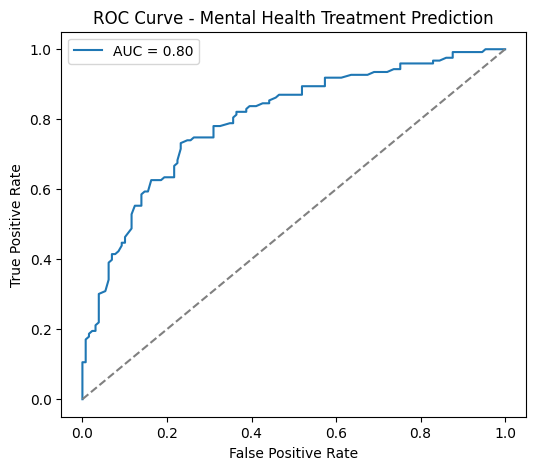

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Mental Health Treatment Prediction")
plt.legend()
plt.show()


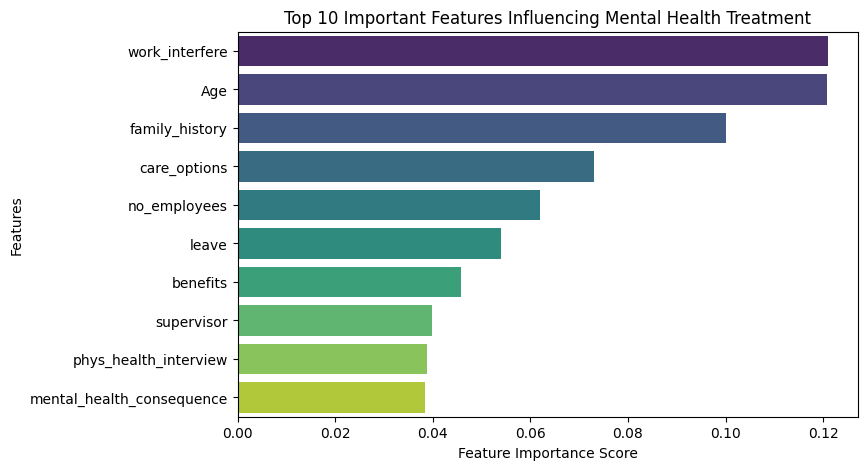

In [ ]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features, y=top_features.index, palette="viridis")
plt.title("Top 10 Important Features Influencing Mental Health Treatment")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_proba = xgb.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score
print("XGBoost AUC:", roc_auc_score(y_test, y_pred_proba))


XGBoost AUC: 0.7914539610512383
